# Problem
Trời sắp mưa trong khi quần áo chưa thu và không kịp thu
# Solution
Mái che tự động dùng sensor, camera lấy ảnh sau đó cho ra kqua trời mưa hay không -> cho mái che ra hay thu mái che lại
(input: ảnh bầu trời)

# 📥 Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras import backend
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Permute, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from time import perf_counter

In [ ]:
backend.set_image_data_format('channels_first')

# 🗃️ Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Giải nén dataset
!mkdir '/content/Images'
!unzip '/content/drive/MyDrive/Perfectly 3lanced/Dataset/images.zip' -d '/content/Images'
# !pwd

Archive:  /content/drive/MyDrive/Perfectly 3lanced/Dataset/images.zip
   creating: /content/Images/images/
  inflating: /content/Images/__MACOSX/._images  
  inflating: /content/Images/images/cloudy126.jpg  
  inflating: /content/Images/__MACOSX/images/._cloudy126.jpg  
  inflating: /content/Images/images/rain20.jpg  
  inflating: /content/Images/__MACOSX/images/._rain20.jpg  
  inflating: /content/Images/images/rain34.jpg  
  inflating: /content/Images/__MACOSX/images/._rain34.jpg  
  inflating: /content/Images/images/cloudy132.jpg  
  inflating: /content/Images/__MACOSX/images/._cloudy132.jpg  
  inflating: /content/Images/images/sunrise33.jpg  
  inflating: /content/Images/__MACOSX/images/._sunrise33.jpg  
  inflating: /content/Images/images/sunrise27.jpg  
  inflating: /content/Images/__MACOSX/images/._sunrise27.jpg  
  inflating: /content/Images/images/shine22.jpg  
  inflating: /content/Images/__MACOSX/images/._shine22.jpg  
  inflating: /content/Images/images/shine36.jpg  
  inf

In [ ]:
path = '/content/Images/images'
path_imgs = list(glob.glob(path+'/*.jpg'))
# path_imgs
len(path_imgs)

1122

In [ ]:
def get_label(img_path): 
  file_name = os.path.split(img_path)[1]
  re = ""
  for c in file_name: 
    if '0' <= c and c <= '9': 
      return re
    else:
      re = re + c


In [ ]:
# get_label('rain03.jpg')
labels = list(map(get_label, path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()
len(data)

1122

# 🔥 EDA & Visualization

---



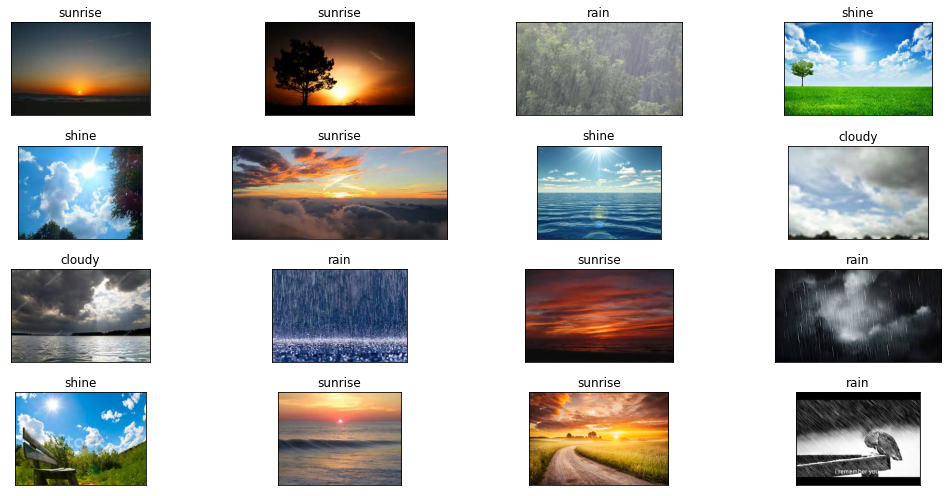

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    # print(i, ax)
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

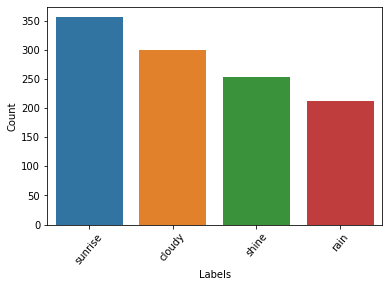

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

# ✂️ Train & Test Split

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

# 🦾 Functions

In [ ]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(3, 100, 100),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [ ]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [ ]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [ ]:
training_time = []

# 📚 Training models

# ✔️ EfficientNetB7

Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
258088960/258076736 [==============================] - 4s 0us/step
[84.17]
trained in 84.17 sec
              precision    recall  f1-score   support

      cloudy       0.92      0.88      0.90        68
        rain       0.95      0.98      0.96        42
       shine       0.78      0.96      0.86        49
     sunrise       0.98      0.85      0.91        66

    accuracy                           0.91       225
   macro avg       0.91      0.92      0.91       225
weighted avg       0.92      0.91      0.91       225



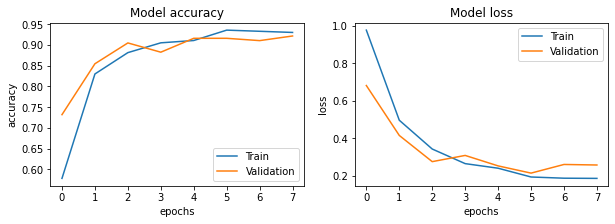

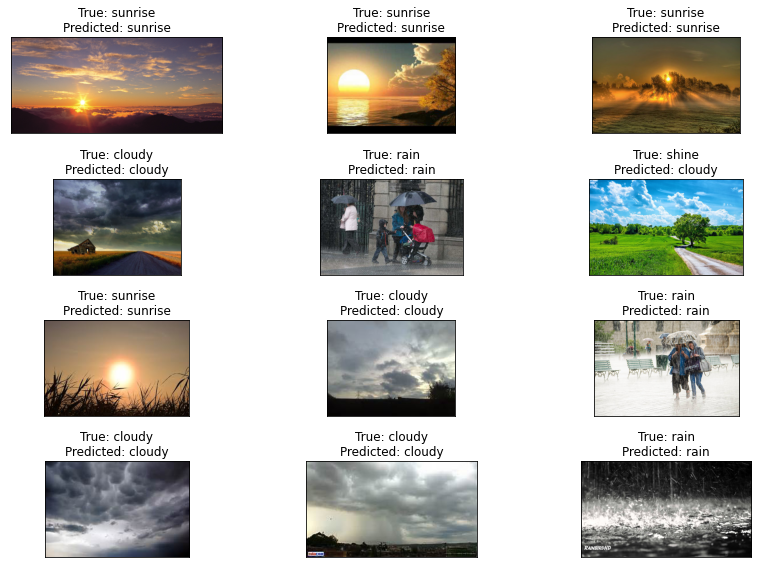

    Test Loss: 0.26746
Test Accuracy: 90.67%


In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
ENet_pre=preprocess_input
train_gen_ENet, valid_gen_ENet, test_gen_ENet = gen(ENet_pre,train_df,test_df)
ENet_model, callback=func(EfficientNetB7)
start = perf_counter()
history = ENet_model.fit(
    train_gen_ENet,
    validation_data=valid_gen_ENet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

ENet_model.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/ENet_model.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/ENet_model.hdf5")

history_ENet=plot(history,test_gen_ENet,train_gen_ENet, ENet_model)
result_ENet = result_test(test_gen_ENet,ENet_model)



```
# This is formatted as code
```

# ✔️ ResNet50


Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
94781440/94765736 [==============================] - 1s 0us/step
[84.17, 21.06]
trained in 21.06 sec
              precision    recall  f1-score   support

      cloudy       0.92      1.00      0.96        68
        rain       1.00      1.00      1.00        42
       shine       1.00      0.90      0.95        49
     sunrise       1.00      0.98      0.99        66

    accuracy                           0.97       225
   macro avg       0.98      0.97      0.97       225
weighted avg       0.98      0.97      0.97       225



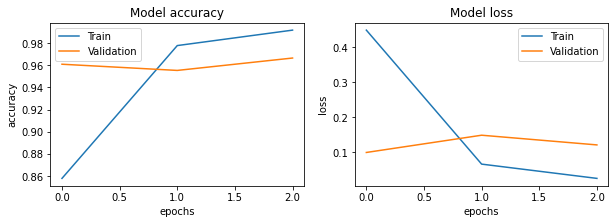

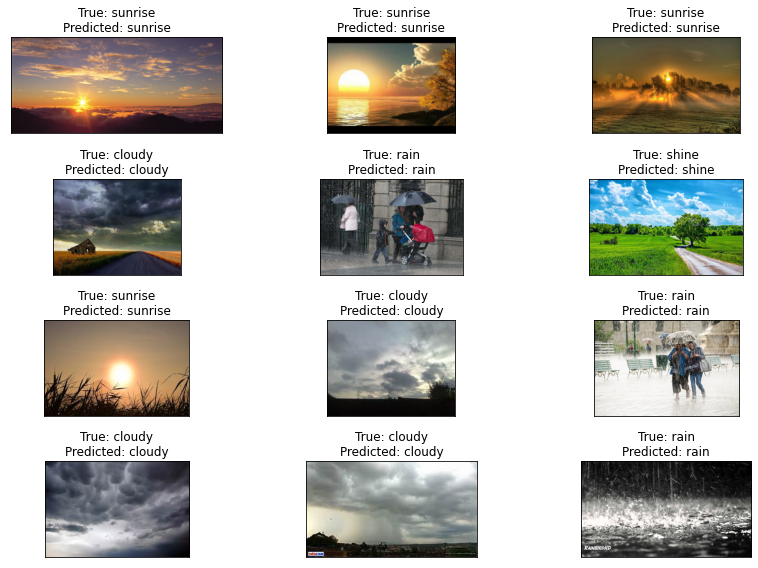

    Test Loss: 0.09628
Test Accuracy: 97.33%


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = gen(ResNet_pre,train_df,test_df)
ResNet_model, callback=func(ResNet50)
start = perf_counter()
history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

ResNet_model.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/ResNet_model.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/ResNet_model.hdf5")

history_ResNet= plot(history,test_gen_ResNet,train_gen_ResNet, ResNet_model)

result_ResNet = result_test(test_gen_ResNet,ResNet_model)

# ✔️ MobileNet

Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
17235968/17225924 [==============================] - 0s 0us/step
[84.17, 21.06, 31.98]
trained in 31.98 sec
              precision    recall  f1-score   support

      cloudy       0.91      0.94      0.93        68
        rain       0.91      1.00      0.95        42
       shine       0.84      0.78      0.81        49
     sunrise       0.97      0.94      0.95        66

    accuracy                           0.92       225
   macro avg       0.91      0.91      0.91       225
weighted avg       0.91      0.92      0.91       225



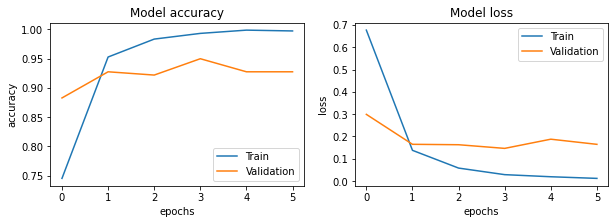

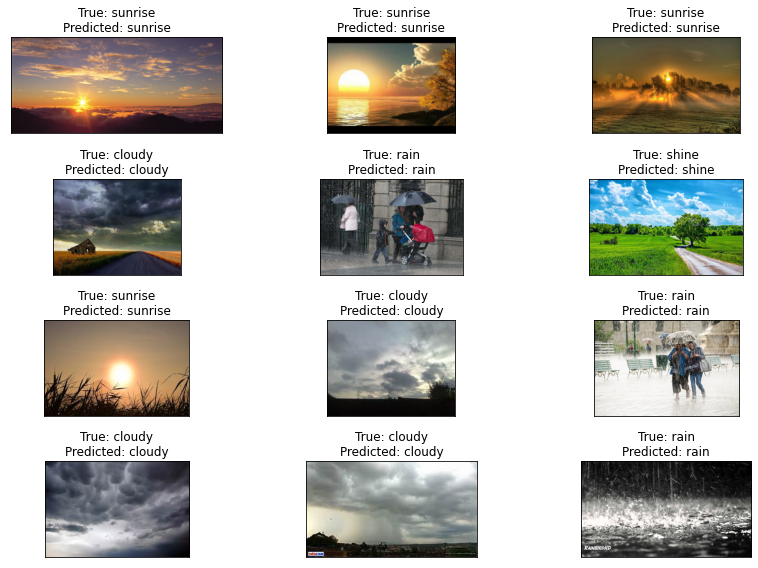

    Test Loss: 0.25344
Test Accuracy: 91.56%


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=func(MobileNet)
start = perf_counter()
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

MobileNet_model.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/MobileNet_model.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/MobileNet_model.hdf5")

history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

# ✔️ VGG19

Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
80150528/80134624 [==============================] - 1s 0us/step
[84.17, 21.06, 31.98, 38.26]
trained in 38.26 sec
              precision    recall  f1-score   support

      cloudy       0.96      0.94      0.95        68
        rain       0.87      0.95      0.91        42
       shine       0.91      0.80      0.85        49
     sunrise       0.93      0.97      0.95        66

    accuracy                           0.92       225
   macro avg       0.91      0.91      0.91       225
weighted avg       0.92      0.92      0.92       225



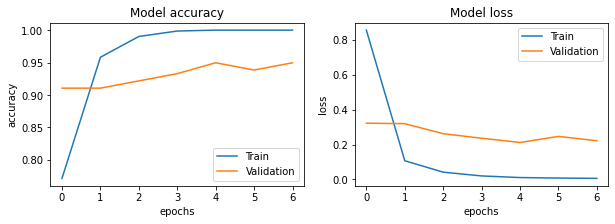

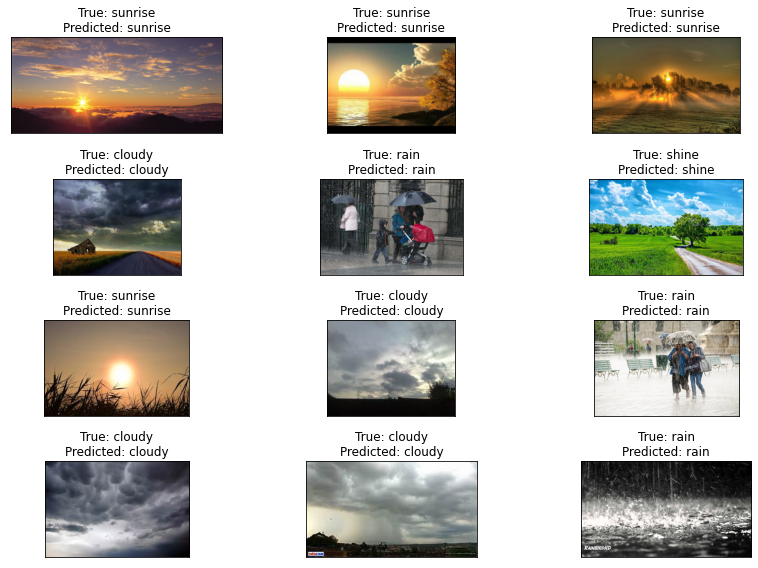

    Test Loss: 0.20881
Test Accuracy: 92.00%


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
VGG19_pre=preprocess_input
train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = gen(VGG19_pre,train_df,test_df)
VGG19_model, callback=func(VGG19)
start = perf_counter()
history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

VGG19_model.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/VGG19_model.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/VGG19_model.hdf5")

history_VGG19= plot(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = result_test(test_gen_VGG19,VGG19_model)

# ✔️ Xception

Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
83697664/83683744 [==============================] - 1s 0us/step
[84.17, 21.06, 31.98, 38.26, 39.9]
trained in 39.9 sec
              precision    recall  f1-score   support

      cloudy       0.97      0.84      0.90        68
        rain       0.93      0.98      0.95        42
       shine       0.82      0.94      0.88        49
     sunrise       0.97      0.97      0.97        66

    accuracy                           0.92       225
   macro avg       0.92      0.93      0.92       225
weighted avg       0.93      0.92      0.92       225



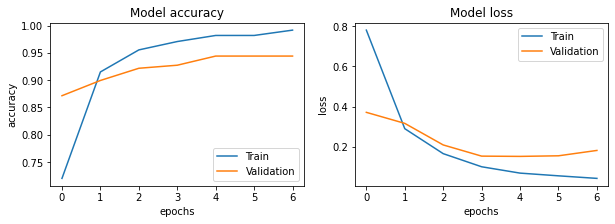

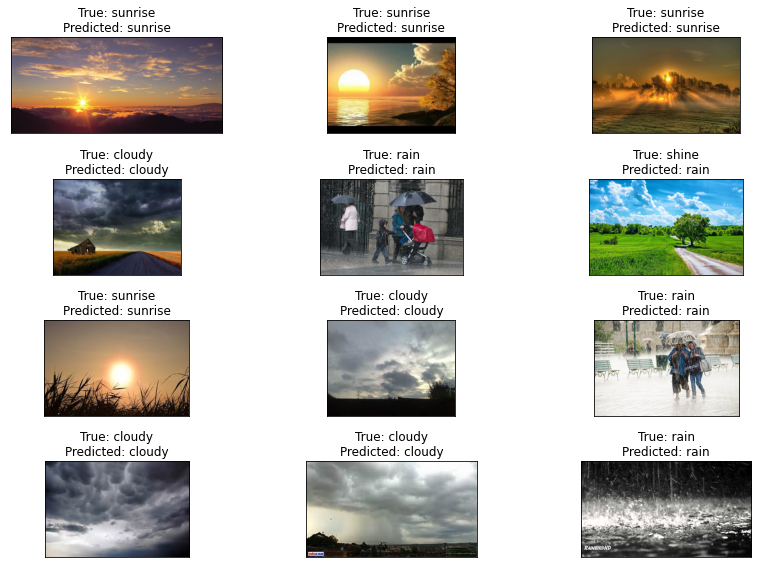

    Test Loss: 0.27162
Test Accuracy: 92.44%


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)
Xception_model, callback=func(Xception)
start = perf_counter()
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

Xception_model.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/Xception_model.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/Xception_model.hdf5")

history_Xception = plot(history,test_gen_Xception,train_gen_Xception, Xception_model)
result_Xception = result_tresult_Xception = result_test(test_gen_Xception,Xception_model)

# ✔️ InceptionResNetV2

Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
219070464/219055592 [==============================] - 6s 0us/step
[84.17, 21.06, 31.98, 38.26, 39.9, 36.2]
trained in 36.2 sec
              precision    recall  f1-score   support

      cloudy       0.95      0.90      0.92        68
        rain       0.85      0.95      0.90        42
       shine       0.81      0.88      0.84        49
     sunrise       0.98      0.91      0.94        66

    accuracy                           0.91       225
   macro avg       0.90      0.91      0.90       225
weighted avg       0.91      0.91      0.91       225



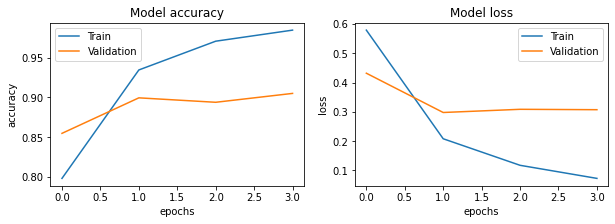

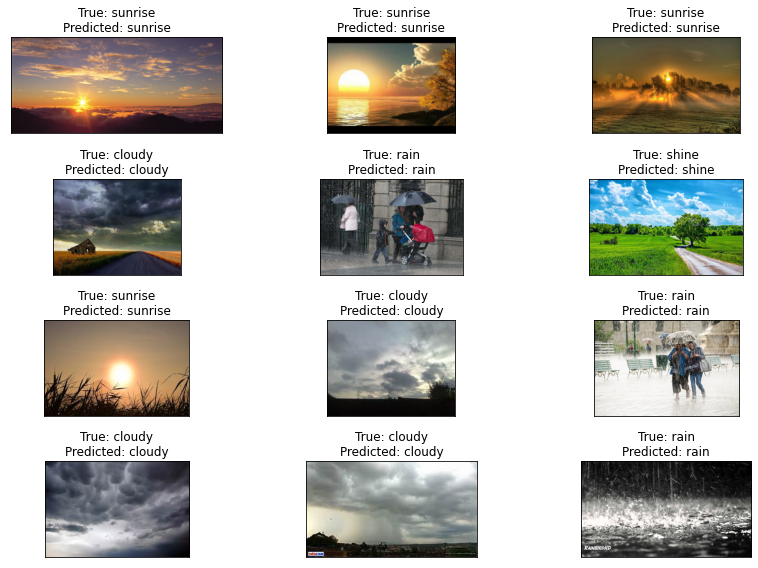

    Test Loss: 0.33409
Test Accuracy: 90.67%


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
IRNV2_pre=preprocess_input
train_gen_IRNV2, valid_gen_IRNV2, test_gen_IRNV2 = gen(IRNV2_pre,train_df,test_df)
IRNV2_model, callback=func(InceptionResNetV2)
start = perf_counter()
history = IRNV2_model.fit(
    train_gen_IRNV2,
    validation_data=valid_gen_IRNV2,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

IRNV2_model.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/IRNV2_model.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/IRNV2_model.hdf5")

history_IRNV2 =plot(history,test_gen_IRNV2,train_gen_IRNV2, IRNV2_model)
result_IRNV2 = result_tresult_IRNV2 = result_test(test_gen_IRNV2,IRNV2_model)

# ✔️ VGG16

Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
58900480/58889256 [==============================] - 0s 0us/step
[84.17, 21.06, 31.98, 38.26, 39.9, 36.2, 31.7]
trained in 31.7 sec
              precision    recall  f1-score   support

      cloudy       0.98      0.96      0.97        68
        rain       0.95      1.00      0.98        42
       shine       0.90      0.92      0.91        49
     sunrise       0.98      0.97      0.98        66

    accuracy                           0.96       225
   macro avg       0.96      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225



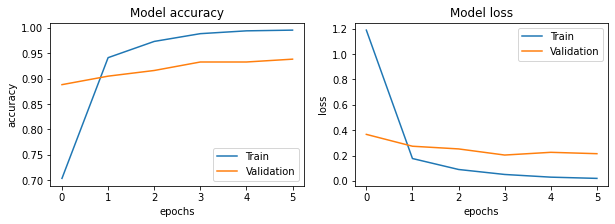

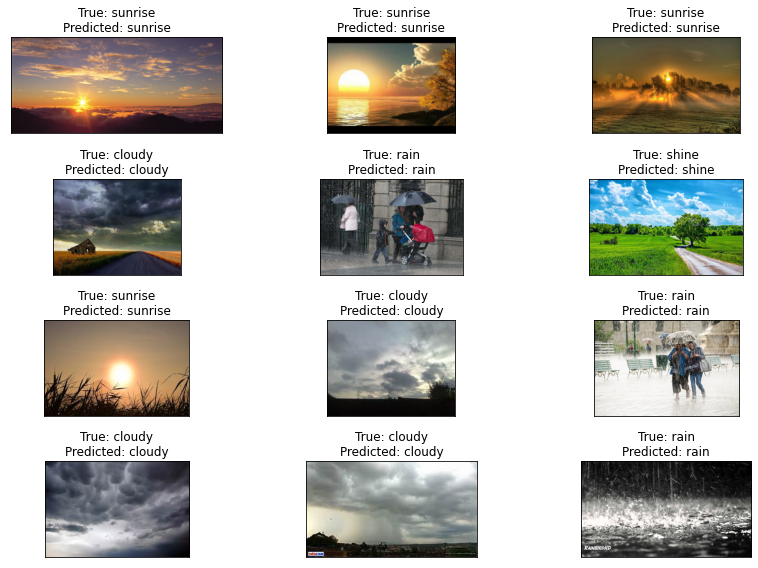

    Test Loss: 0.12214
Test Accuracy: 96.00%


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)
model_VGG16, callback=func(VGG16)
start = perf_counter()
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

model_VGG16.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/model_VGG16.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/model_VGG16.hdf5")

history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)
result_VGG16 = result_test(test_gen_VGG,model_VGG16)

# ✔️ ResNet101

Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
171458560/171446536 [==============================] - 5s 0us/step
[84.17, 21.06, 31.98, 38.26, 39.9, 36.2, 31.7, 60.57]
trained in 60.57 sec
              precision    recall  f1-score   support

      cloudy       0.97      0.99      0.98        68
        rain       0.98      1.00      0.99        42
       shine       0.98      0.92      0.95        49
     sunrise       0.97      0.98      0.98        66

    accuracy                           0.97       225
   macro avg       0.97      0.97      0.97       225
weighted avg       0.97      0.97      0.97       225



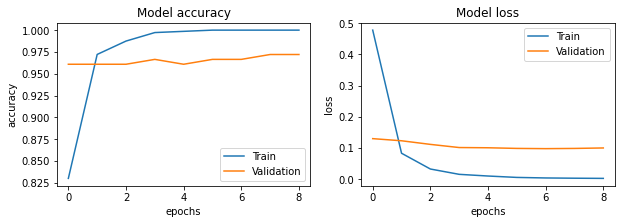

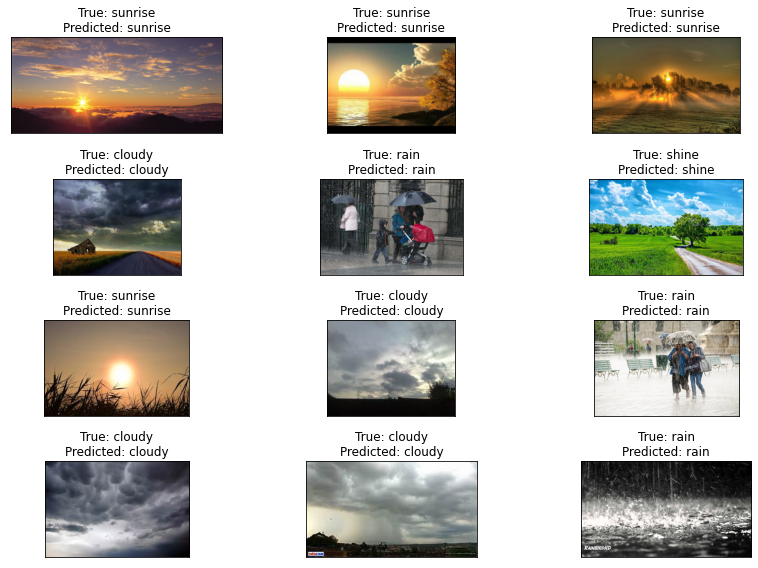

    Test Loss: 0.09944
Test Accuracy: 97.33%


In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

ResNet101_pre=preprocess_input
train_gen_ResNet101, valid_gen_ResNet101, test_gen_ResNet101 = gen(ResNet101_pre,train_df,test_df)
model_ResNet101, callback=func(ResNet101)
start = perf_counter()
history = model_ResNet101.fit(
    train_gen_ResNet101,
    validation_data=valid_gen_ResNet101,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

model_ResNet101.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/model_ResNet101.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/model_ResNet101.hdf5")

history=plot(history,test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)
result_ResNet101 = result_test(test_gen_ResNet101,model_ResNet101)

# ✔️ DenseNet201

Found 718 validated image filenames belonging to 4 classes.
Found 179 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.
74850304/74836368 [==============================] - 2s 0us/step
[84.17, 21.06, 31.98, 38.26, 39.9, 36.2, 31.7, 60.57, 65.92]
trained in 65.92 sec
              precision    recall  f1-score   support

      cloudy       0.98      0.90      0.94        68
        rain       0.93      1.00      0.97        42
       shine       0.94      0.94      0.94        49
     sunrise       0.96      1.00      0.98        66

    accuracy                           0.96       225
   macro avg       0.95      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225



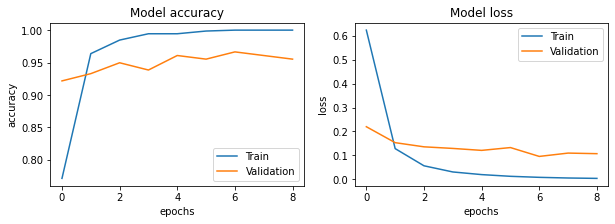

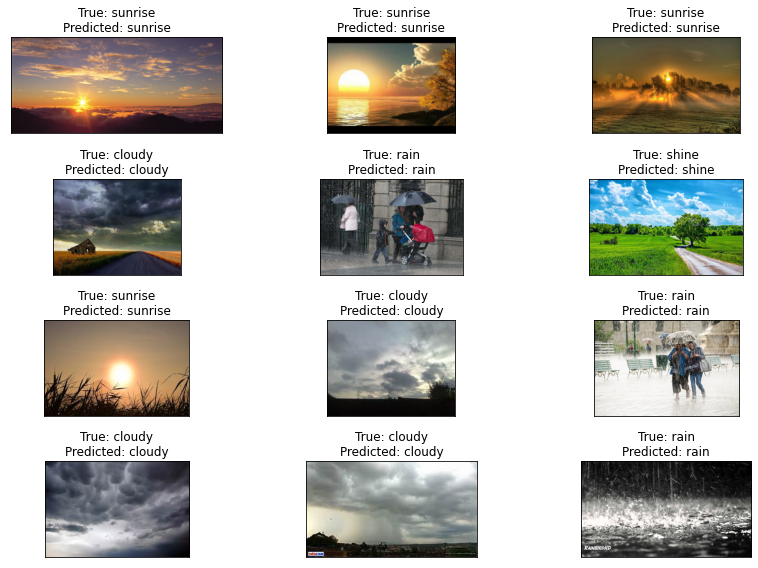

    Test Loss: 0.13900
Test Accuracy: 95.56%


In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df,test_df)
model_DenseNet201, callback=func(DenseNet201)
start = perf_counter()
history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
duration = perf_counter() - start
duration = round(duration,2)
training_time.append(duration)
print(training_time)
print(f"trained in {duration} sec")

model_DenseNet201.save("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/model_DenseNet201.hdf5")
model = load_model("/content/drive/MyDrive/Perfectly 3lanced/Colab Notebooks/Saved_models/model_DenseNet201.hdf5")

history=plot(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

# 📊 Final Report

In [ ]:
print(training_time)

[84.17, 21.06, 31.98, 38.26, 39.9, 36.2, 31.7, 60.57, 65.92]


In [ ]:
output = pd.DataFrame({'Model':['EfficientNetB7','ResNet50','MobileNet','VGG19','Xception','InceptionResNetV2',
                               'VGG16','ResNet101','DenseNet201'],
                      'Accuracy':[result_ENet[1], result_ResNet[1], result_MobileNet[1], result_VGG19[1],
                                  result_Xception[1],result_IRNV2[1],result_VGG16[1],result_ResNet101[1],
                                 result_DenseNet201[1]],
                      'Training time': [training_time[i] for i in range (9)]})

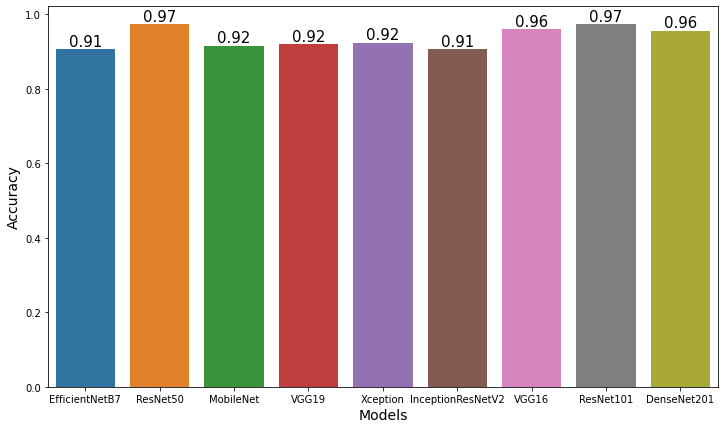

In [ ]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()

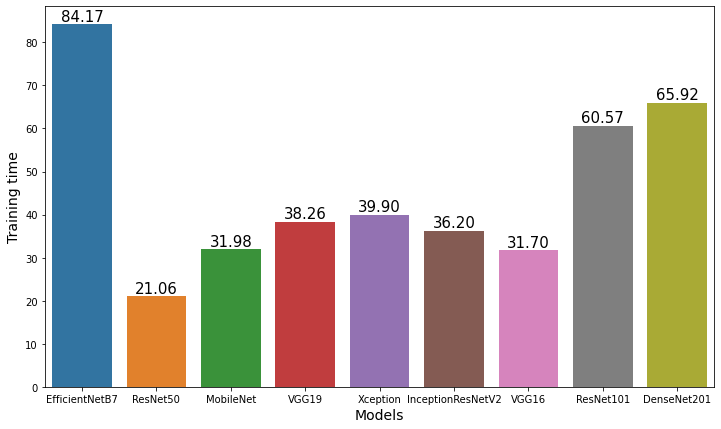

In [ ]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Training time', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Training time", size=14)
plt.show()